# Advanced Coding Group Project - 2024/25 
#### Students: Michele Turco, Mattia Cervelli, Lorenzo Laterza 

## 0) Import Libraries and the Dataset

Setup your python environment and download the credit-score data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [3]:
credit_card_df = pd.read_csv('train_biased.csv')

## 1) Understanding the dataset



#### 1.1) General overview of the dataset

Using the function `.head()`, we can extract from the dataset the first x rows (x=5 by default, but we can change this number). They are not useful for analytic purposes, but still enable us to visualize the dataset.
After that, it is possible to explicitly check the number of rows and columns in the dataset using the function `.shape`.


In [4]:
# Head of the DataFrame
print("Head of the DataFrame:")
print(credit_card_df.head())
print("\n")

# Identify Number of Columns and Rows
n_rows = len(credit_card_df)
n_columns = len(credit_card_df.columns)
print(f"The dataset contains {n_columns} columns")
print(f"The dataset contains {n_rows} rows")


Head of the DataFrame:
       ID Customer_ID     Month           Name    City         Street    Age  \
0     NaN   CUS_0xd40       NaN  Aaron Maashoh  Lonton  Oxford Street    NaN   
1  0x1603   CUS_0xd40  February  Aaron Maashoh  Lonton  Oxford Street   23.0   
2  0x1604   CUS_0xd40       NaN            NaN  Lonton  Oxford Street -500.0   
3  0x1605   CUS_0xd40     April  Aaron Maashoh  Lonton  Oxford Street   23.0   
4     NaN   CUS_0xd40       May  Aaron Maashoh  Lonton  Oxford Street   23.0   

           SSN Occupation Annual_Income  ...  Num_of_Delayed_Payment  \
0  821-00-0265    Manager      19114.12  ...                       7   
1  821-00-0265    Manager      19114.12  ...                     NaN   
2  821-00-0265    Manager      19114.12  ...                       7   
3  821-00-0265    Manager      19114.12  ...                       4   
4  821-00-0265    Manager      19114.12  ...                     NaN   

   Changed_Credit_Limit  Num_Credit_Inquiries  Credit_Mix Outst

We continued our first and superficial analysis of the dataset by retrieving the names of the columns and their data types. This is done using the function `.dtypes`, in order to understand the nature of the data we are dealing with and to check if there are any inconsistencies in the dataset (e.g. a column that should be numeric but is stored as a string). 
In addition, we can also check the number of missing values in each column using the function `.isnull().sum()`. This is useful to understand if we need to impute the dataset before proceeding with the analysis. 
Finally, we can also check the number of unique values in each column using the function `.nunique()`, which is relevant to discover the categorical variables in the dataset.

In [5]:
# Create a DataFrame with column data types and number of unique values
column_summary = pd.DataFrame({
    "Data Type": credit_card_df.dtypes,
    "Unique Values": credit_card_df.nunique(),
    "Missing Values": credit_card_df.isnull().sum(),
})

# Display the combined summary
print(column_summary)

                         Data Type  Unique Values  Missing Values
ID                          object          90058            9942
Customer_ID                 object          12500            9893
Month                       object              8            9938
Name                        object          10139           18887
City                        object              4            9851
Street                      object             31            9920
Age                        float64           1501           14488
SSN                         object          12501           10001
Occupation                  object             21            9944
Annual_Income               object          18438           10094
Monthly_Inhand_Salary      float64          13204           23595
Num_Bank_Accounts          float64            879            9833
Num_Credit_Card            float64           1132           10062
Interest_Rate              float64           1597            9849
Num_of_Loa

Many columns, such as **Annual Income**, are classified as categorical. Upon inspecting the dataset, we observed that several of these columns contain special characters like `"_ \@ $"`, which cause the values to be treated as objects instead of numbers. To address this, we replace these special characters with an empty string `''`. This process may introduce new missing values, but it is necessary for accurate analysis. A cell containing only special characters provides no meaningful information and can be reasonably treated as a missing value.

In [6]:
def simple_clean_numeric(df, cols):
    
    """
    Convert specified columns to numeric by removing any non-digit characters 
    (except for period and minus sign) and then converting to numeric.
    
    Parameters:
      df: pandas DataFrame
      cols: List of column names to clean and convert
      
    Returns:
      A new DataFrame with the specified columns cleaned and converted to numeric.
    """
    
    df_clean = df.copy()
    for col in cols:
        if col in df_clean.columns:
            # Convert to string and remove all characters except digits, period, and minus sign.
            cleaned = df_clean[col].astype(str).str.replace(r'[^0-9\.-]', '', regex=True)
            # Convert the cleaned string to numeric (float); unconvertible values become NaN.
            df_clean[col] = pd.to_numeric(cleaned, errors='coerce')
    return df_clean

# List of columns that should be numeric
should_be_numeric = [
    'Annual_Income', 
    'Num_of_Loan', 
    'Num_of_Delayed_Payment', 
    'Changed_Credit_Limit', 
    'Outstanding_Debt', 
    'Amount_invested_monthly'
]

# Clean and convert the data
credit_card_df = simple_clean_numeric(credit_card_df, should_be_numeric)

# Verify that the columns are now numeric
print(credit_card_df[should_be_numeric].dtypes)


Annual_Income              float64
Num_of_Loan                float64
Num_of_Delayed_Payment     float64
Changed_Credit_Limit       float64
Outstanding_Debt           float64
Amount_invested_monthly    float64
dtype: object


After converting the columns to numeric, we can correctly check the data types of the columns again using the function `.dtypes`. This allows us to verify that the columns are now in the appropriate format for analysis, as well as to split the dataset into categorical and numerical variables. 

In [7]:
##Selecting numerical features
numerical_data = credit_card_df.select_dtypes(include='number')
#append the features of numerical_data to list
numerical_features = numerical_data.columns.tolist()

#Selecting categoricalfeatures
categorical_data = credit_card_df.select_dtypes(include= 'object')
#append the features of categorical_data to list
categorical_features = categorical_data.columns.tolist()

print(f'There are {len(numerical_features)} numerical features:')
print(numerical_features)
print('\n')
print(f'There are {len(categorical_features)} categorical features:')
print(categorical_features)

There are 15 numerical features:
['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Amount_invested_monthly', 'Credit_Score']


There are 12 categorical features:
['ID', 'Customer_ID', 'Month', 'Name', 'City', 'Street', 'SSN', 'Occupation', 'Type_of_Loan', 'Credit_Mix', 'Credit_History_Age', 'Payment_of_Min_Amount']


Now that we have all the numerical features in the correct format, we can proceed with a further analysis of the dataset. We can check the summary statistics of the dataset using the function `.describe()`, which provides useful information such as the mean, standard deviation, minimum and maximum values, and quartiles for each numerical column. This is useful to understand the distribution of the data and to identify any potential outliers.

In [8]:
credit_card_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,85512.0,110.226845,6.849076e+02,-500.000000,24.000000,33.000000,42.000000,8.698000e+03
Annual_Income,89906.0,176544.795590,1.429013e+06,7005.930000,19453.050000,37579.750000,72760.040000,2.419806e+07
Monthly_Inhand_Salary,76405.0,4185.789272,3.178561e+03,303.645417,1625.023750,3086.683333,5940.317500,1.520463e+04
Num_Bank_Accounts,90167.0,17.105172,1.177282e+02,-1.000000,3.000000,6.000000,7.000000,1.798000e+03
Num_Credit_Card,89938.0,22.449410,1.290372e+02,0.000000,4.000000,5.000000,7.000000,1.499000e+03
Interest_Rate,90151.0,72.343923,4.656848e+02,1.000000,8.000000,13.000000,20.000000,5.797000e+03
Num_of_Loan,89809.0,3.065116,6.319337e+01,-100.000000,1.000000,3.000000,5.000000,1.496000e+03
Delay_from_due_date,90012.0,21.081156,1.486271e+01,-5.000000,10.000000,18.000000,28.000000,6.700000e+01
Num_of_Delayed_Payment,83782.0,31.041369,2.263703e+02,-3.000000,9.000000,14.000000,18.000000,4.388000e+03
Changed_Credit_Limit,88058.0,10.389097,6.782829e+00,-6.490000,5.340000,9.410000,14.860000,3.697000e+01


We can instantly see that the dataset contains some strange values. As an example, the column **Age** has both negative (minimun value = -500) and very high values (maximum value = 8698). 
It is also possible to note that the target variable **Credit Score** score is more a categorical variable than a continuous one, as it has only 4 unique values. As a consequence, we will convert the target variable into a categorical variable.

In [9]:
# Convert target variable to object type
credit_card_df['Credit_Score'] = credit_card_df['Credit_Score'].astype('object')

# Display the summary statistics for categorical features
credit_card_df.describe(include="object").T

,count,unique,top,freq
ID,90058,90058,0x1603,1
Customer_ID,90107,12500,CUS_0x2646,8
Month,90062,8,April,11319
Name,81113,10139,Langep,42
City,90149,4,Standhampton,47744
Street,90080,31,Quality Street,5343
SSN,89999,12501,#F%$D@*&8,5008
Occupation,90056,21,Journalist,17002
Type_of_Loan,79688,6260,Not Specified,1272
Credit_Mix,90085,4,Standard,32875


We firstly tried to plot the distribution of numerical variables without addressing outliers or noisy values. However, the presence of outliers and extreme values in the dataset made it difficult to visualize the distribution effectively. 
To improve the visualization, we decided to remove outliers from the dataset. However, because of the presence of an high number of missing values, we had to address them first.

## 1.2) Missing values and imputation

The dataset contains numerous missing values, likely due to poor data collection or entry errors. It is also possible that an event occurred, leading to the loss of many values. However, we observe that there are only 12,500 unique `Customer_ID` values across 100,000 entries. This indicates that many customers are repeated throughout the dataset. Consequently, for missing values that should remain consistent for the same customer, we can impute them using the corresponding values from other rows associated with the same customer.

The first issue to fix is hence to address the missing values in the `Customer_ID` column. 

In [10]:
missing_customerID = credit_card_df['Customer_ID'].isnull().sum()
print(f"Missing Customer_ID: {missing_customerID}")

Missing Customer_ID: 9893


By looking at the dataset, we could see that the rows are ordered by `Customer_ID`. This means that we can simply fill the missing values with the previous value in the column as long as the following value (or the first that is not missing) is the same.
Also, we can check if there is a 1 to 1 correspondence between the `Customer_ID` and the `Name` columns. If this is the case, we can also fill the missing values in the `Name` column using the same logic.

In [11]:
""" DO NOT RUN THIS CODE, STILL IN PROGRESS: IT COULD BE AN IMPROVEMENT FOR THE IMPUTATION OF CUSTOMER_ID


df_name_id = credit_card_df[["Customer_ID", "Name"]]

# Drop Rows with Missing Values in Customer_ID or Name
df_name_id = df_name_id.dropna(subset=["Customer_ID", "Name"])
print("After dropping rows with missing values:")
print(f"Number of rows: {len(df_name_id)}")

# Drop Duplicates from the DataFrame
print("Before dropping duplicates:")
print(f"Number of rows: {len(df_name_id)}")
df_name_id = df_name_id.drop_duplicates(subset=["Customer_ID", "Name"])
print("After dropping duplicates:")
print(f"Number of rows: {len(df_name_id)}")

print("After dropping duplicates:")
# Check for duplicates Customer_IDs
duplicates = df_name_id[df_name_id.duplicated(subset='Customer_ID', keep=False)]
print(f"Number of duplicate Customer_IDs: {len(duplicates)}")

# Check for duplicates for name
duplicates_name = df_name_id[df_name_id.duplicated(subset='Name', keep=False)]
print(f"Number of duplicate Names: {len(duplicates_name)}")

# Print the first few rows of the duplicates DataFrame
print("Duplicates DataFrame:")
print(duplicates_name.head())

# Count the number of unique Customer_IDs for each Name
name_id_counts = df_name_id.groupby("Name")["Customer_ID"].nunique().reset_index()
name_id_counts.columns = ["Name", "Unique_Customer_IDs"]

# Store in a dictionary the unique Customer_IDs for each Name only if there is only one unique Customer_ID
name_id_dict = {}
for index, row in name_id_counts.iterrows():
    if row["Unique_Customer_IDs"] == 1:
        name_id_dict[row["Name"]] = df_name_id[df_name_id["Name"] == row["Name"]]["Customer_ID"].values[0]

# Fill in the missing Customer_IDs in the original DataFrame
credit_card_df["Customer_ID"] = credit_card_df["Customer_ID"].fillna(
    credit_card_df["Name"].map(name_id_dict)
)
# Check for any remaining missing values in Customer_ID
missing_customerID = credit_card_df["Customer_ID"].isnull().sum()
print(f"Missing Customer_ID after filling: {missing_customerID}")


"""



' DO NOT RUN THIS CODE, STILL IN PROGRESS: IT COULD BE AN IMPROVEMENT FOR THE IMPUTATION OF CUSTOMER_ID\n\n\ndf_name_id = credit_card_df[["Customer_ID", "Name"]]\n\n# Drop Rows with Missing Values in Customer_ID or Name\ndf_name_id = df_name_id.dropna(subset=["Customer_ID", "Name"])\nprint("After dropping rows with missing values:")\nprint(f"Number of rows: {len(df_name_id)}")\n\n# Drop Duplicates from the DataFrame\nprint("Before dropping duplicates:")\nprint(f"Number of rows: {len(df_name_id)}")\ndf_name_id = df_name_id.drop_duplicates(subset=["Customer_ID", "Name"])\nprint("After dropping duplicates:")\nprint(f"Number of rows: {len(df_name_id)}")\n\nprint("After dropping duplicates:")\n# Check for duplicates Customer_IDs\nduplicates = df_name_id[df_name_id.duplicated(subset=\'Customer_ID\', keep=False)]\nprint(f"Number of duplicate Customer_IDs: {len(duplicates)}")\n\n# Check for duplicates for name\nduplicates_name = df_name_id[df_name_id.duplicated(subset=\'Name\', keep=False)]\np

In [12]:
# Function to fill missing Customer_ID values based on matching names
def fill_missing_customer_id(df):
    """
    Fill missing Customer_ID values using the most common ID for each name.
    
    Parameters:
        df: The input DataFrame with Name and Customer_ID columns
    
    Returns:
        DataFrame with missing Customer_ID values filled
    """
    # Count missing values before
    missing_before = df['Customer_ID'].isnull().sum()
    print(f"Missing Customer_ID values before: {missing_before}")
    
    # Check if there are any missing values to fill
    if missing_before == 0:
        print("No missing Customer_ID values to fill.")
        return df
    
    # Create a copy to avoid modifying the original during calculation
    result_df = df.copy()
    
    # Only use rows that have both a Name and a valid Customer_ID to compute the mode
    valid = df.dropna(subset=['Name', 'Customer_ID'])
    
    # Find the most common Customer_ID for each Name
    mode_mapping = valid.groupby('Name')['Customer_ID'].agg(lambda x: x.mode().iloc[0] if not x.empty else None)
    
    # Create a mask for rows with missing Customer_ID
    missing_mask = result_df['Customer_ID'].isnull()
    
    # Apply the mapping in one vectorized operation
    result_df.loc[missing_mask, 'Customer_ID'] = result_df.loc[missing_mask, 'Name'].map(mode_mapping)
    
    # Count missing values after filling
    missing_after = result_df['Customer_ID'].isnull().sum()
    print(f"Missing Customer_ID values after: {missing_after}")
    print(f"Fixed {missing_before - missing_after} values ({(missing_before - missing_after)/missing_before:.2%} of missing values)")
    
    # Check if any values couldn't be filled
    if missing_after > 0:
        print(f"Warning: Could not fill {missing_after} Customer_ID values because their Names don't match any known Customer_ID")
    
    return result_df

# Apply the function to fix missing Customer_ID values
credit_card_df = fill_missing_customer_id(credit_card_df)

Missing Customer_ID values before: 9893
Missing Customer_ID values after: 1891
Fixed 8002 values (80.89% of missing values)


We now need to visualize if there are some rows wurh missing values inn both the `Customer_ID` and the `Name` columns.

In [13]:
# Check for missing values in Customer_ID and Name
missing_rows = credit_card_df[credit_card_df['Customer_ID'].isnull() & credit_card_df['Name'].isnull()]
print(f"Number of rows with missing Customer_ID and Name: {len(missing_rows)}")
# Get the indices of the rows with missing Customer_ID and Name
missing_rows_indices = missing_rows.index.tolist()
print(f"Indices of rows with missing Customer_ID and Name: {missing_rows_indices}")

Number of rows with missing Customer_ID and Name: 1891
Indices of rows with missing Customer_ID and Name: [108, 109, 216, 241, 311, 367, 489, 539, 587, 668, 693, 704, 747, 765, 837, 865, 875, 1127, 1229, 1320, 1344, 1421, 1433, 1518, 1530, 1556, 1753, 1786, 1817, 1837, 1842, 1873, 1882, 1907, 1967, 1977, 1984, 2007, 2022, 2030, 2209, 2247, 2434, 2445, 2500, 2526, 2537, 2551, 2678, 2727, 2834, 2886, 2917, 3048, 3101, 3148, 3157, 3279, 3284, 3382, 3555, 3571, 3629, 3664, 3717, 3769, 3784, 3816, 3823, 3913, 3980, 4151, 4200, 4220, 4223, 4231, 4317, 4398, 4399, 4790, 4820, 4833, 4854, 4937, 4946, 4949, 5046, 5069, 5122, 5131, 5154, 5176, 5186, 5203, 5283, 5426, 5462, 5534, 5554, 5585, 5613, 5672, 5687, 5785, 5811, 5856, 5957, 5983, 6038, 6074, 6087, 6156, 6287, 6310, 6358, 6388, 6578, 6622, 6750, 6877, 6883, 7098, 7101, 7104, 7203, 7209, 7227, 7318, 7338, 7510, 7569, 7761, 7784, 7804, 7849, 7853, 7945, 7958, 7960, 7969, 8035, 8072, 8175, 8283, 8306, 8488, 8588, 8630, 8715, 8731, 8737, 8755

#### Theory of subsequential dataset

We found out that each client has a monthly analysis of his credit cards on a range of months that goes from january to august. Here we want to prove that we can fix the remaining missing values for customer ID going in one of the other lines that are i range of january august and fix it. 

In [14]:
# Calculate the number of rows per customer
rows_per_customer = credit_card_df.groupby('Customer_ID').size()
print("Average entries per customer:", rows_per_customer.mean())

Average entries per customer: 7.84872


With this, we confirmed that each customer has an average of 8 rows (this is accurate since there are only 1891 missing Customer_IDs out of 100,000 entries). As the length of the range of months between January and August is 8, we can proceed to fix all the remaining missing Customer_IDs by first addressing the 'Month' column.

Example of correct order:
| Customer_ID | Month    |
|-------------|----------|
| Client 1    | January  |
| Client 1    | February |
| Client 1    | March    |
| Client 1    | April    |
| Client 1    | May      |
| Client 1    | June     |
| Client 1    | July     |
| Client 1    | August   |

Example of incorrect order:
| Customer_ID | Month    |
|-------------|----------|
| Client 1    | January  |
| Client 2    | January  |
| Client 1    | February |
| Client 3    | March    |
| Client 1    | June     |
| Client 5    | April    |


In [15]:
# Define the expected month order.
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August']

# Reset the index to ensure we're working on the DataFrame's natural order (if needed)
credit_card_df = credit_card_df.reset_index(drop=True)

# Create a new month column with a repeating cycle: each group of 8 rows gets January to August.
credit_card_df['Month'] = [month_order[i % 8] for i in range(len(credit_card_df))]

# Check Missing Values in the Month Column
missing_month = credit_card_df['Month'].isnull().sum()
print(f"Missing Month values: {missing_month}")

Missing Month values: 0


In [16]:
# Define the month order and a mapping to positions (0 for January, …, 7 for August).
month_to_index = {month: i for i, month in enumerate(month_order)}

def fill_missing_customer_id(df):
    df = df.copy()
    n_rows = len(df)
    
    # Iterate over each row where Customer_ID is missing.
    for idx, row in df[df['Customer_ID'].isna()].iterrows():
        # Determine the cycle position based on the assigned month.
        # If for some reason month is missing, default to position 0.
        m = row.get('Month', None)
        m_index = month_to_index.get(m, 0)
        
        # Define the search window:
        # Look m rows upward and (7 - m_index) rows downward.
        window_start = max(idx - m_index, 0)
        window_end = min(idx + (7 - m_index), n_rows - 1)
        
        # Extract the window of rows.
        window = df.loc[window_start:window_end, 'Customer_ID']
        # Get all non-missing Customer_ID values in that window.
        non_missing_ids = window.dropna().unique()
        
        if len(non_missing_ids) == 1:
            # If exactly one unique non-missing Customer_ID is found, assign it.
            df.at[idx, 'Customer_ID'] = non_missing_ids[0]
        elif len(non_missing_ids) > 1:
            # If multiple candidate IDs are found, you could choose the first one,
            # or implement more sophisticated logic (e.g. mode, or nearest by distance).
            df.at[idx, 'Customer_ID'] = non_missing_ids[0]
        else:
            # If no candidate is found in the immediate window, you may decide to extend the search.
            # For now, we'll leave it missing.
            pass
    return df

# Example usage:
credit_card_df= fill_missing_customer_id(credit_card_df)

# Check for any remaining missing values in Customer_ID
print(f"Missing Customer_ID after filling: {credit_card_df['Customer_ID'].isnull().sum()}")


Missing Customer_ID after filling: 0


### Filling the columns 'Name', 'City', 'Street' and 'Occupation'

For these columns we follow the principle we used before and we scan through the lines which have the same Customer ID to find the missing name city street and occupation that for sure won't change between January and August

In [17]:
cols_invariant = ['Name', 'City', 'Street', 'Occupation']
for col in cols_invariant:
    credit_card_df[col] = credit_card_df.groupby('Customer_ID')[col].transform(lambda x: x.ffill().bfill())

# Check for any remaining missing values in the columns
missing_values = credit_card_df[cols_invariant].isnull().sum()
print(f"Missing values in invariant columns after filling: {missing_values}")


Missing values in invariant columns after filling: Name          0
City          0
Street        0
Occupation    0
dtype: int64


### Fixing Age

With the age column, we identified two main issues:

1. **Inconsistent values across months:**  
        For some customers, the age values fluctuate unrealistically between months. For example, in January, a customer might have an age of 23, in February -500 (which is impossible), and in March, it reverts back to 23. These anomalies will be addressed later, but for now, we need to replace such values with a reasonable temporary solution.

2. **Age increment due to birthdates between January and August:**  
        Many customers have their birthdays between January and August, causing their age to increase by one year during this period. For these cases, it is acceptable to have some rows with one age value (e.g., 54) and others with the incremented value (e.g., 55). 

To handle this, we substiute the missing values or the values that have a difference with the previous one of more than 1 with the value of the previous month. If the latter is not available, we can use the next month value.

In [18]:
def clean_age_column(df):
    """
    For the same customer, if the value in the 'Age' column is greater than the subsequent
    or precedent value by more than one, replace it with the precedent value if available,
    otherwise use the subsequent value. Also, fill NaN values with the precedent value
    if available, otherwise use the subsequent value.
    
    Parameters:
        df: pandas DataFrame
    
    Returns:
        DataFrame with cleaned 'Age' column
    """
    df = df.copy()
    
    # Remove values wuth 'Age' greater than 100 and less than 0, put them to NaN
    df.loc[(df['Age'] > 100) | (df['Age'] < 0), 'Age'] = np.nan

    # If the value in the 'Age' column is greater than the subsequent or precedent value by more than one,
    # replace it with the precedent value if available, otherwise use the subsequent value.

    for idx in range(1, len(df)):
        if pd.isna(df.at[idx, 'Age']):
            # If the current value is NaN, check the precedent and subsequent values and fill accordingly
            if idx > 0 and not pd.isna(df.at[idx - 1, 'Age']): # precedent value
                df.at[idx, 'Age'] = df.at[idx - 1, 'Age']
            elif idx < len(df) - 1 and not pd.isna(df.at[idx + 1, 'Age']): # subsequent value
                df.at[idx, 'Age'] = df.at[idx + 1, 'Age']
        else:
            # If the current value is not NaN, check the precedent and subsequent values
            if idx > 0 and abs(df.at[idx, 'Age'] - df.at[idx - 1, 'Age']) > 1:
                df.at[idx, 'Age'] = df.at[idx - 1, 'Age']
            if idx < len(df) - 1 and abs(df.at[idx, 'Age'] - df.at[idx + 1, 'Age']) > 1:
                df.at[idx, 'Age'] = df.at[idx + 1, 'Age']

    
    # Fill any remaining NaN values with the precedent value if available, otherwise use the subsequent value
    df['Age'] = df['Age'].fillna(method='ffill').fillna(method='bfill')

    return df

credit_card_df = clean_age_column(credit_card_df)


# Check for any remaining missing values in the Age column
print(f"Missing Age values after filling: {credit_card_df['Age'].isnull().sum()}")

Missing Age values after filling: 0


C:\Users\Utente\AppData\Local\Temp\ipykernel_34532\2838330964.py:38: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Age'] = df['Age'].fillna(method='ffill').fillna(method='bfill')


### Filling Missing SSN Values
We have a column called SSN that represents the Social Security Number, which should uniquely identify a customer. In our dataset, each customer appears in 8 consecutive rows (one per month from January to August). Since a customer's SSN is expected to remain constant over time, any missing or invalid SSN in one row can be reliably filled using a valid SSN from another row belonging to the same customer.

Our approach is as follows:
1. **Clean the SSN values:**  
   We define a function to verify if the SSN matches the standard format (three digits, a dash, two digits, a dash, and four digits). Values that do not meet this pattern or that correspond to known placeholders are set as missing (NaN).

2. **Fill missing values:**  
   By grouping the data using the Customer_ID, we can apply forward fill and backward fill within each group. This ensures that if at least one valid SSN exists among the 8 rows for the same customer, it is propagated to fill any missing values.

This method leverages the consistency of SSN within each customer group and the sequential structure of the dataset.

In [19]:
# 1) Convert special placeholders into NaN.
def is_valid_ssn(x):
    """
    Checks if x matches the typical SSN format: 3 digits, '-', 2 digits, '-', 4 digits.
    Example: 821-00-0265
    """
    pattern = r'^\d{3}-\d{2}-\d{4}$'
    return bool(re.match(pattern, str(x)))

def clean_ssn(ssn_value):
    """
    If ssn_value does not match the SSN pattern, return NaN.
    """
    if ssn_value is None:
        return np.nan
    ssn_str = str(ssn_value)
    # Treat certain special strings as missing values:
    # e.g., #F%$D@*&8, missing, Missing value, etc.
    placeholders = {"#F%$D@*&8", "Missing value", "_", ""}  # Example placeholders
    if ssn_str in placeholders or not is_valid_ssn(ssn_str):
        return np.nan
    return ssn_str

# Apply the cleaning function to the 'SSN' column
credit_card_df['SSN'] = credit_card_df['SSN'].apply(clean_ssn)

# 2) Group by Customer_ID and apply forward fill (ffill) and backward fill (bfill)
credit_card_df['SSN'] = credit_card_df.groupby('Customer_ID')['SSN'].transform(lambda x: x.ffill().bfill())

# 3) Check for any remaining missing values in the SSN column
missing_ssn = credit_card_df['SSN'].isnull().sum()
print(f"Missing SSN values after filling: {missing_ssn}")

Missing SSN values after filling: 0


### Checking Column Consistency Across Customer Records
We suspect that some columns (for example, Annual_Income, Monthly_Inhand_Salary, Num_Bank_Accounts, Num_Credit_Card, Interest_Rate, and Num_of_Loan) should remain constant over the 8 monthly records for each customer. However, there is a possibility that for some columns (such as Monthly_Inhand_Salary) the values might change from month to month. 

To decide if we can impute missing values using the same method as before (forward fill and backward fill based on Customer_ID), we first need to verify that the values in these columns do not vary within the same customer. The code below groups the data by Customer_ID and computes the number of unique values for each candidate column obviously excluding the missing values. This allows us to calculate the percentage of customers that have more than one unique value per column.

In [20]:
# Define the candidate columns that might be invariant across months for each customer
candidate_cols = [
    "Annual_Income",
    "Monthly_Inhand_Salary",
    "Num_Bank_Accounts",
    "Num_Credit_Card",
    "Interest_Rate",
    "Num_of_Loan"
]

consistency_results = {}

# Group the dataframe by Customer_ID and calculate the number of unique non-missing values for each column in each group
for col in candidate_cols:
    group_nunique = credit_card_df.groupby("Customer_ID")[col].nunique(dropna=True)  # ignore NaN
    customers_with_variation = (group_nunique > 1).sum()
    total_customers = group_nunique.shape[0]
    proportion_with_variation = customers_with_variation / total_customers
    consistency_results[col] = proportion_with_variation

print("Proportion of customers with variation in each column (ignoring NaNs):")
for column, prop_var in consistency_results.items():
    print(f"{column}: {prop_var:.2%}")

Proportion of customers with variation in each column (ignoring NaNs):
Annual_Income: 15.03%
Monthly_Inhand_Salary: 13.13%
Num_Bank_Accounts: 18.18%
Num_Credit_Card: 23.90%
Interest_Rate: 20.87%
Num_of_Loan: 32.76%


### Filling Missing Values for Columns with Low Variation

Based on the consistency check, some columns (for example, Annual_Income, Monthly_Inhand_Salary, and Num_Bank_Accounts) show variation in only around 15–18% of customers. For these columns, we can assume that they are mostly invariant per customer. Therefore, we can impute missing values by grouping by Customer_ID and using forward fill followed by backward fill to propagate the available value.

For columns that exceed a chosen variation threshold (e.g., more than 20% variation), a different imputation strategy will be necessary, but for now we focus on the ones that appear to be invariant.

In [21]:
# Choose a threshold for variation (here we use 20%)
variation_threshold = 0.20

# Identify columns that are considered invariant (low variation)
invariant_cols = [col for col, prop in consistency_results.items() if prop < variation_threshold]

print("Columns assumed to be invariant:", invariant_cols)

# Impute missing values for these invariant columns using forward fill and backward fill by Customer_ID
for col in invariant_cols:
    # Drop impossible values (e.g., negative values for Annual_Income)
    if col == 'Annual_Income':
        credit_card_df[col] = credit_card_df[col].where(credit_card_df[col] >= 0, np.nan)
    elif col == "Num_Bank_Accounts":
        credit_card_df[col] = credit_card_df[col].where((credit_card_df[col] >= 0) & (credit_card_df[col] <= 100), np.nan)
    
    
    # Group by Customer_ID and propagate non-missing values within each group
    credit_card_df[col] = credit_card_df.groupby('Customer_ID')[col].transform(lambda x: x.ffill().bfill())

Columns assumed to be invariant: ['Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts']


### Analysis for columns which have more than 20% 

After analyzing our dataset and examining the distributions of various numeric columns, we noticed that for **Interest_Rate**, **Num_Credit_Card**, and **Num_of_Loan** the distributions (when excluding extreme outliers) are very tight and consistent within each customer. Although we observe some variation, most of it is due to outlier values or data entry errors. Therefore, these columns should ideally be invariant for each customer. 

Based on the distribution analysis and summary statistics, we concluded that imputing missing values with the mode (i.e., the most common valid value) for each customer is the best approach. This method leverages the fact that, apart from a few anomalous outliers, the true value remains constant over time. The code below fills in the missing values for these three columns by grouping the data by `Customer_ID` and replacing missing values with the mode of the group.

In [22]:
# Impute missing values for the selected columns using the mode within each Customer_ID group
columns_to_impute = ["Interest_Rate", "Num_Credit_Card", "Num_of_Loan"]

# For each of these columns, fill missing values with the mode of the values within each customer group
for col in columns_to_impute:
    # Drop impossible values (e.g., negative values for Interest_Rate)
    if col == 'Interest_Rate':
        credit_card_df[col] = credit_card_df[col].where(credit_card_df[col] >= 0, np.nan)
    elif col == "Num_Credit_Card":
        credit_card_df[col] = credit_card_df[col].where((credit_card_df[col] >= 0) & (credit_card_df[col] <= 100), np.nan)
    elif col == "Num_of_Loan":
        credit_card_df[col] = credit_card_df[col].where((credit_card_df[col] >= 0) & (credit_card_df[col] <= 100), np.nan)
    credit_card_df[col] = credit_card_df.groupby("Customer_ID")[col].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan))

credit_card_df.isnull().sum()

ID                           9942
Customer_ID                     0
Month                           0
Name                            0
City                            0
Street                          0
Age                             0
SSN                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary           0
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                20312
Delay_from_due_date          9988
Num_of_Delayed_Payment      16218
Changed_Credit_Limit        11942
Num_Credit_Inquiries        11898
Credit_Mix                   9915
Outstanding_Debt             9963
Credit_Utilization_Ratio     9975
Credit_History_Age          18209
Payment_of_Min_Amount        9957
Amount_invested_monthly     14120
Credit_Score                    0
dtype: int64

### Filling the 'Type_of_Loan' Missing Values

For the 'Type_of_Loan' column, we noticed that the value is the same for all records of a given customer or not specified. We therefore impute missing values by grouping the dataset by `Customer_ID` and replacing missing entries with the most frequent (mode) value in that group. However, if all the records for a customer are missing, we fill those missing values with the string "Not Specified", which is appropriate for a categorical variable.

In [23]:
# Print the unique values for the columns type of loan
unique_loans = credit_card_df['Type_of_Loan'].unique()
print("Unique values in 'Type_of_Loan':", unique_loans)

Unique values in 'Type_of_Loan': ['Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan'
 'Credit-Builder Loan' 'Auto Loan, Auto Loan, and Not Specified' ...
 'Home Equity Loan, Auto Loan, Auto Loan, and Auto Loan'
 'Payday Loan, Student Loan, Mortgage Loan, and Not Specified'
 'Personal Loan, Auto Loan, Mortgage Loan, Student Loan, and Student Loan']


In [24]:
def fill_type_of_loan(group):
    # Remove missing values from the group
    valid = group.dropna()
    # If the group is completely missing values, fill all with 'Not Specified'
    if valid.empty:
        return group.fillna("Not Specified")
    else:
        # Otherwise, compute the mode (most frequent value)
        mode_val = valid.mode().iloc[0]
        # Fill missing values with the computed mode
        return group.fillna(mode_val)

# Apply the function on the 'Type_of_Loan' column grouped by Customer_ID
credit_card_df['Type_of_Loan'] = credit_card_df.groupby("Customer_ID")['Type_of_Loan'].transform(fill_type_of_loan)

After this analysis we noticed that in the next columns of the dataset we have some columns that follow the path and others that clearly changes entries between each row of the same customer. For those we'll proceed later. The columns that we can fill as we did so far are: 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_History_Age'. For credit history age we have this format for a client:

| Customer_ID | Credit_History_Age|
|-------------|----------|
| Client 1    | 22y and 1m |
| Client 1    | 22y and 2m |
| Client 1    | 22y and 3m |
| Client 1    | 22y and 4m |
| Client 1    | 22y and 5m |
| Client 1    | 22y and 6m |
| Client 1    | 22y and 7m |
| Client 1    | 22y and 8m |

As the year is the same and the month change, we can use the customer ID and the month together to fill the missing values for this column

In [25]:
# Impute missing values for 'Num_Credit_Inquiries' and 'Outstanding_Debt'
for col in ["Num_Credit_Inquiries", "Outstanding_Debt"]:
    credit_card_df[col] = credit_card_df.groupby("Customer_ID")[col].transform(lambda x: x.ffill().bfill())


Our plan is to impute any missing values in 'Credit_History_Age' by:
1. Determining the common year for that customer using any non-missing entry.
2. Retrieving the month for the current row from the 'Month' column (by mapping the month name to a number from 1 to 8).
3. Constructing a value in the format: "YY Years and X Months", where "YY" is the common year and "X" is the mapped month number.

In [26]:
# Define a helper function to convert the string format into total months
def convert_to_months(ch_str):
    """
    Converts a string like '22 Years and 4 Months'
    to an integer representing the total number of months.
    """
    if pd.isna(ch_str):
        return np.nan  # return NaN if the value is missing
    # Use regex to extract the numbers for years and months.
    match = re.search(r'(\d+)\s*Years?\s*and\s*(\d+)\s*Months?', ch_str)
    if match:
        years = int(match.group(1))
        months = int(match.group(2))
        return years * 12 + months
    return np.nan

# Define a helper function to convert total months back to the formatted string
def convert_from_months(total_months):
    """
    Converts a total number of months into a string in the format:
    '<years> Years and <months> Months'
    """
    if pd.isna(total_months):
        return np.nan
    years = int(total_months) // 12
    months = int(total_months) % 12
    return f"{years} Years and {months} Months"

In [27]:
# Create a new column with the total months representation
credit_card_df['Credit_History_Age'] = credit_card_df['Credit_History_Age'].apply(convert_to_months)

# Perform linear interpolation on the numeric column.
# This will fill missing values by assuming the pattern is linear (one month increment as in your example).
credit_card_df['Credit_History_Age'] = credit_card_df['Credit_History_Age'].interpolate(method='linear', limit_direction='both')

# Convert the interpolated numeric values back to the original string format
credit_card_df['Credit_History_Age'] = credit_card_df['Credit_History_Age'].apply(convert_from_months)



We used the Interquartile Range (IQR) method to identify and remove these outliers. The IQR is a measure of statistical dispersion and is calculated as the difference between the 75th percentile (Q3) and the 25th percentile (Q1) of the data. Any data point that falls below $Q1 - 1.5 \times IQR$ or above $Q3 + 1.5 \times IQR$ is considered an outlier.

In [28]:
## Removing outliers from the dataset

def remove_outliers(df, column):
    """
    Remove outliers from a specified column in a DataFrame using the IQR method.
    
    Parameters:
      df: pandas DataFrame
      column: Column name from which to remove outliers
      
    Returns:
      A new DataFrame with outliers removed from the specified column.
    """
    
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 10 * IQR
    upper_bound = Q3 + 10 * IQR
    
    # Filter the DataFrame to remove outliers
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

print(f"Shape of the DataFrame before removing outliers: {credit_card_df.shape}")

# Loop through each numerical feature and remove outliers
for col in numerical_features:
    credit_card_df = remove_outliers(credit_card_df, col)

# Display the shape of the DataFrame after removing outliers
print(f"Shape of the DataFrame after removing outliers: {credit_card_df.shape}")

Shape of the DataFrame before removing outliers: (100000, 27)
Shape of the DataFrame after removing outliers: (46407, 27)


Plot the distribution of credit card score respect to a normal distribution to see i there are skewnesses

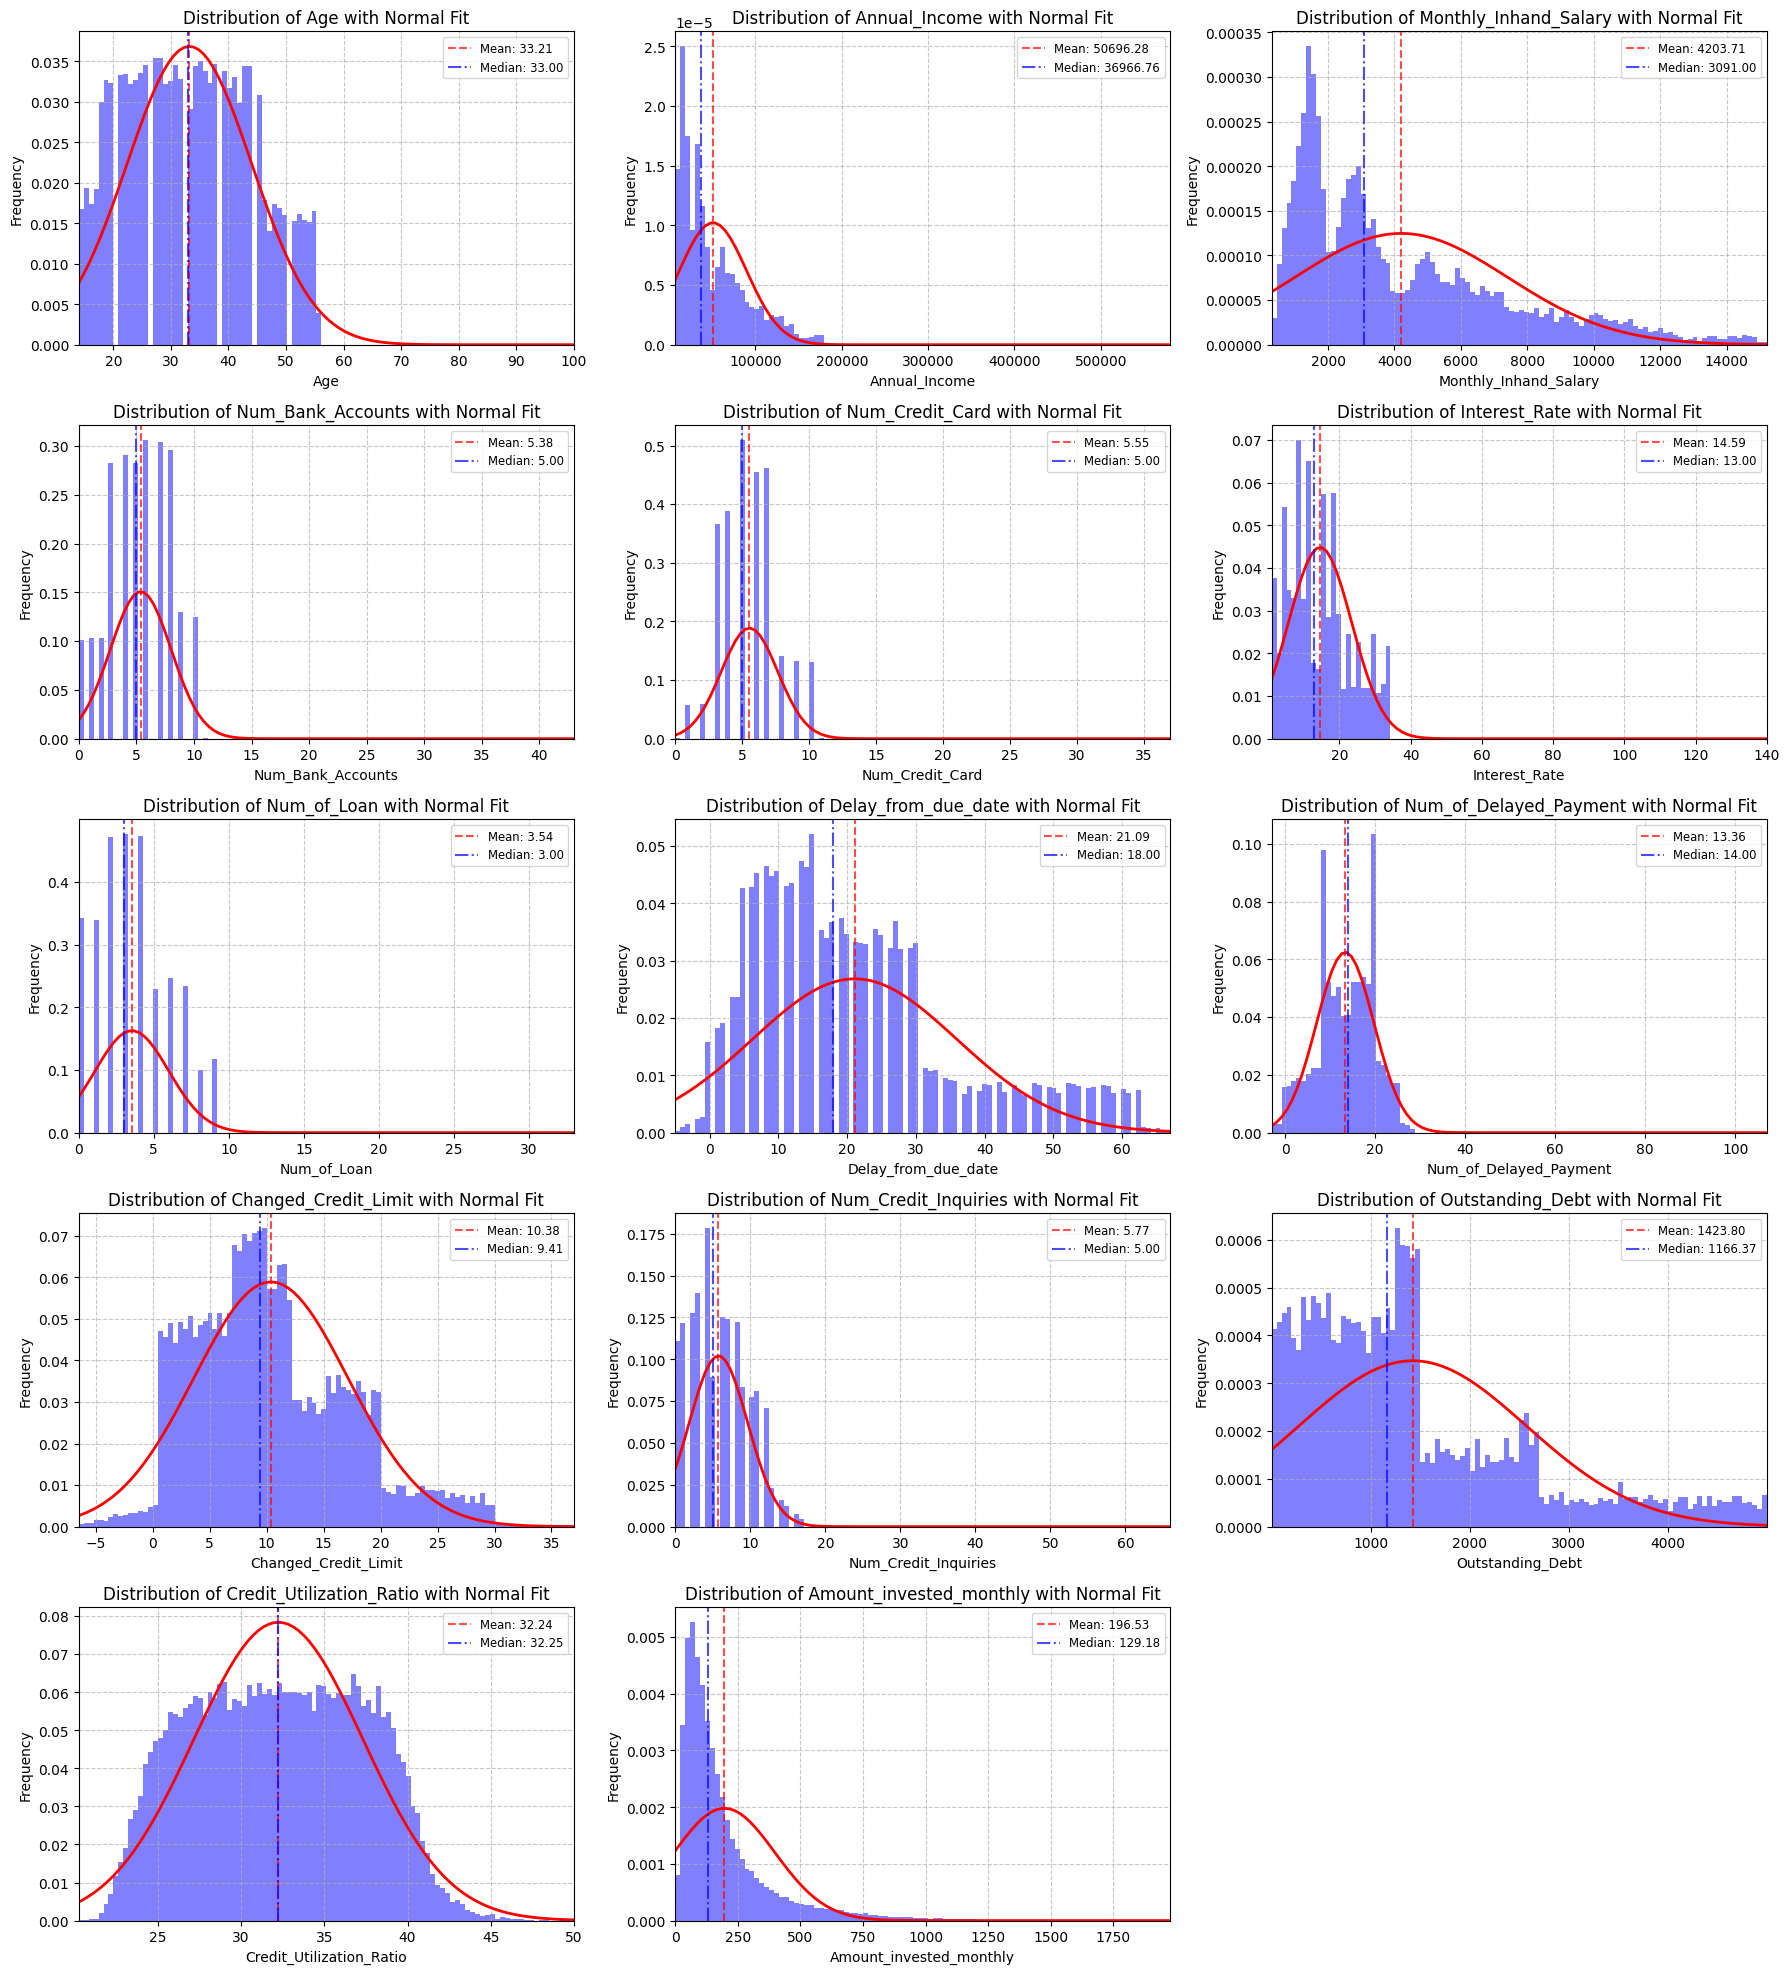

In [29]:
from scipy.stats import norm


# Get the list of numerical feature names from the cleaned dataframe.
numeric_features = credit_card_df.select_dtypes(include=['number']).columns
n_features = len(numeric_features)

# Define grid size
n_cols = 3  # Number of columns in the grid
n_rows = (n_features + n_cols - 1) // n_cols  # Calculate required number of rows

# Create subplots with a grid layout
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Loop through all numerical features and plot their distributions
for i, col in enumerate(numeric_features):
    ax = axes[i]
    data = credit_card_df[col].dropna()
    
    # Plot histogram with density normalization
    n_bins = 0
    ax.hist(data, bins=100, density=True, alpha=0.5, color='blue')
    ax.set_xlim(data.min(), data.max())  # Set x-axis limits to focus on the range of interest
    
    # Fit a normal distribution to the data and plot it
    mu, std = norm.fit(data)
    x = np.linspace(data.min(), data.max(), 100)
    y = norm.pdf(x, mu, std)
    ax.plot(x, y, 'r-', lw=2)
    
    # Add vertical lines for mean and median
    mean_val = data.mean()
    median_val = data.median()
    ax.axvline(mean_val, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_val:.2f}')
    ax.axvline(median_val, color='blue', linestyle='-.', alpha=0.7, label=f'Median: {median_val:.2f}')
    
    # Add legend, grid, and style ticks
    ax.legend(fontsize='small')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    # Set titles and labels
    ax.set_title(f'Distribution of {col} with Normal Fit')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

# Remove any unused subplots if n_features is not a multiple of n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Theory of subsequential dataset

We found out that each client has a monthly analysis of his credit cards on a range of months that goes from january to august. Here we want to prove that we can fix the remaining missing values for customer ID going in one of the other lines that are i range of january august and fix it. 

In [30]:
# Calculate the number of rows per customer
rows_per_customer = credit_card_df.groupby('Customer_ID').size()
print("Average entries per customer:", rows_per_customer.mean())


Average entries per customer: 3.7400870406189557


with this I proved that for each customer we have an average of 8 rows (this is pretty accurate because we have only 1891 missing customer IDs over 100k entries). As the lenght of the range of months between January to August is 8 we can proceed by fixing all the remaining missing customer IDs by fixing before the column 'Month'. Before doing this we need to prove that we have a precise number of rows for each client and this is the same for everyone and the clients are in order.

ex. 
| Customer_ID | Month    |
|-------------|----------|
| Client 1    | January  |
| Client 1    | February |
| Client 1    | March    |
| Client 1    | April    |
| Client 1    | May      |
| Client 1    | June     |
| Client 1    | July     |
| Client 1    | August   |

and not something like that

| Customer_ID | Month    |
|-------------|----------|
| Client 1    | January  |
| Client 2    | January  |
| Client 1    | February |
| Client 3    | March    |
| Client 1    | June     |
| Client 5    | April    |

In [31]:
# print me the first 8 rows of the dataset
print(credit_card_df.head(8))

        ID Customer_ID     Month             Name          City  \
0      NaN   CUS_0xd40   January    Aaron Maashoh        Lonton   
6   0x1608   CUS_0xd40      July    Aaron Maashoh        Lonton   
8   0x160e  CUS_0x21b1   January  Rick Rothackerj  Standhampton   
9   0x160f  CUS_0x21b1  February  Rick Rothackerj        Lonton   
10  0x1610  CUS_0x21b1     March  Rick Rothackerj  Standhampton   
12     NaN  CUS_0x21b1       May  Rick Rothackerj        Lonton   
13  0x1613  CUS_0x21b1      June  Rick Rothackerj        Lonton   
15  0x1615  CUS_0x21b1    August  Rick Rothackerj        Lonton   

           Street   Age          SSN Occupation  Annual_Income  ...  \
0   Oxford Street  23.0  821-00-0265    Manager       19114.12  ...   
6   Oxford Street  23.0  821-00-0265    Manager       19114.12  ...   
8      Old Street  23.0  004-07-5839    Teacher       34847.84  ...   
9      Old Street  28.0  004-07-5839    Teacher       34847.84  ...   
10     Old Street  28.0  004-07-5839    T

In [36]:
# print me the last 8 rows of the dataset
print(credit_card_df.tail(8))

            ID Customer_ID    Month            Name          City  \
99979  0x25fd1  CUS_0xaf61    April  Chris Wickhamm        Lonton   
99982      NaN  CUS_0xaf61     July  Chris Wickhamm        Lonton   
99983  0x25fd5  CUS_0xaf61   August  Chris Wickhamm        Lonton   
99984  0x25fda  CUS_0x8600  January  Sarah McBridec      BadShire   
99986      NaN  CUS_0x8600    March  Sarah McBridec      BadShire   
99988  0x25fde  CUS_0x8600      May  Sarah McBridec  Standhampton   
99995  0x25fe9  CUS_0x942c    April           Nicks      BadShire   
99996  0x25fea  CUS_0x942c      May           Nicks      BadShire   

             Street   Age          SSN Occupation  Annual_Income  ...  \
99979    Penny Lane  49.0  133-16-7738     Lawyer       37188.10  ...   
99982    Penny Lane  50.0  133-16-7738     Lawyer       37188.10  ...   
99983    Penny Lane  28.0  133-16-7738     Lawyer       37188.10  ...   
99984    Oak Street  28.0  031-35-0942     Writer       20002.88  ...   
99986    Oak 

$12500 \cdot 8 = 100 000$ which is the exact number of our rows, and as we can see from the previous outputs they're ordered as each client is consequential

In [35]:
# print a specific row of the dataset
print(credit_card_df.iloc[60120])

IndexError: single positional indexer is out-of-bounds

In [ ]:
print(credit_card_df.iloc[60121])

ID                                                                    0x17647
Customer_ID                                                        CUS_0x1011
Month                                                                February
Name                                                                Schneyerh
City                                                             Standhampton
Street                                                             Old Street
Age                                                                      44.0
SSN                                                               793-05-8223
Occupation                                                         Journalist
Annual_Income                                                        58918.47
Monthly_Inhand_Salary                                               5208.8725
Num_Bank_Accounts                                                         3.0
Num_Credit_Card                                                 

after I print the first indexes that are assumed to not be consecutive we can clearly see that we're talking about the same customer as they have the same customer and they have subsequent months so we can proceed by fixing the 'Month' column

In [34]:
# Check remaining missing values after all imputation steps so far
print("Missing values after imputation steps up to Credit_History_Age:")
print(credit_card_df.isnull().sum())

Missing values after imputation steps up to Credit_History_Age:
ID                          4605
Customer_ID                    0
Month                          0
Name                           0
City                           0
Street                         0
Age                            0
SSN                            0
Occupation                     0
Annual_Income                  0
Monthly_Inhand_Salary          0
Num_Bank_Accounts              0
Num_Credit_Card                0
Interest_Rate                  0
Num_of_Loan                    0
Type_of_Loan                   0
Delay_from_due_date            0
Num_of_Delayed_Payment         0
Changed_Credit_Limit           0
Num_Credit_Inquiries           0
Credit_Mix                  4670
Outstanding_Debt               0
Credit_Utilization_Ratio       0
Credit_History_Age             0
Payment_of_Min_Amount       4639
Amount_invested_monthly        0
Credit_Score                   0
dtype: int64
